In [1]:
!python --version

Python 3.7.7


In [2]:
#https://stackoverflow.com/questions/53457975/pyspark-udf-function-error-in-lambda-function
import os
os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'

In [3]:
from pyspark.sql import SparkSession
# https://spark.apache.org/docs/latest/job-scheduling.html
spark = SparkSession.\
        builder.\
        appName("pyspark-notebook2-ais").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "7g").\
        config("spark.cores.max", "3").\
        config("spark.executor.instances", "1").\
        config("spark.executor.cores", "3").\
        config("spark.mongodb.input.uri","mongodb://mongo1:27017,mongo2:27018,mongo3:27019/database.horses_collection?replicaSet=rs0").\
        config("spark.mongodb.output.uri","mongodb://mongo1:27017,mongo2:27018,mongo3:27019/database.horses_collection?replicaSet=rs0").\
        config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
        getOrCreate()


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/spark-3.0.0-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2f89b8f2-87d2-45bd-952a-783abf237ea0;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 294ms :: artifacts dl 17ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 from central in [defaul

In [4]:
spark.catalog.currentDatabase()

'default'

In [5]:
#reading dataframes from MongoDB

# sampleSize - https://stackoverflow.com/a/56255303
df = spark.read.format("mongo").option('sampleSize', 50000).load()
df.createOrReplaceTempView("mongo")


21/12/21 18:16:13 WARN MongoInferSchema: Field 'bsp' contains conflicting types converting to StringType
21/12/21 18:16:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- clk: string (nullable = true)
 |-- mc: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- marketDefinition: struct (nullable = true)
 |    |    |    |-- betDelay: integer (nullable = true)
 |    |    |    |-- bettingType: string (nullable = true)
 |    |    |    |-- bspMarket: boolean (nullable = true)
 |    |    |    |-- bspReconciled: boolean (nullable = true)
 |    |    |    |-- complete: boolean (nullable = true)
 |    |    |    |-- countryCode: string (nullable = true)
 |    |    |    |-- crossMatching: boolean (nullable = true)
 |    |    |    |-- discountAllowed: boolean (nullable = true)
 |    |    |    |-- eachWayDivisor: double (nullable = true)
 |    |    |    |-- eventId: string (nullable = true)
 |    |    |    |-- eventName: string (nullable = true)
 |    |    |    |-- eventTypeId: string (nullable = true)
 | 

In [7]:
df.show()

+--------------------+----------+--------------------+---+-------------+
|                 _id|       clk|                  mc| op|           pt|
+--------------------+----------+--------------------+---+-------------+
|[619e9dd8677066b2...|2480088678|[[1.124699287, [0...|mcm|1462537993283|
|[619e9dd8677066b2...|2480249142|[[1.124699287, [0...|mcm|1462540135101|
|[619e9dd8677066b2...|2481803835|[[1.124699287, [0...|mcm|1462555384075|
|[619e9dd8677066b2...|2481994285|[[1.124699287,, [...|mcm|1462557371191|
|[619e9dd8677066b2...|2482055516|[[1.124699287,, [...|mcm|1462557910955|
|[619e9dd8677066b2...|2482072939|[[1.124699287,, [...|mcm|1462558089056|
|[619e9dd8677066b2...|2482078964|[[1.124699287,, [...|mcm|1462558150717|
|[619e9dd8677066b2...|2482083965|[[1.124699287, [0...|mcm|1462558199155|
|[619e9dd8677066b2...|2482177634|[[1.124699287, [0...|mcm|1462559078531|
|[619e9dd8677066b2...|2480088678|[[1.124699285, [0...|mcm|1462537993283|
|[619e9dd8677066b2...|2480212422|[[1.124699285, [0.

In [8]:
#spark.sql("select * from mongo array_contains(root.mc, array('CLOSED'))").show()
from pyspark.sql.functions import explode   # Explodes lists into rows.

In [9]:
mc_exploded = df.select('*', explode(df.mc).alias('mc_row'))

In [10]:
md_only = mc_exploded.filter(mc_exploded.mc_row.marketDefinition.isNotNull())

In [11]:
md_only.show()

+--------------------+----------+--------------------+---+-------------+--------------------+
|                 _id|       clk|                  mc| op|           pt|              mc_row|
+--------------------+----------+--------------------+---+-------------+--------------------+
|[619e9dd8677066b2...|2480088678|[[1.124699287, [0...|mcm|1462537993283|[1.124699287, [0,...|
|[619e9dd8677066b2...|2480249142|[[1.124699287, [0...|mcm|1462540135101|[1.124699287, [0,...|
|[619e9dd8677066b2...|2481803835|[[1.124699287, [0...|mcm|1462555384075|[1.124699287, [0,...|
|[619e9dd8677066b2...|2482083965|[[1.124699287, [0...|mcm|1462558199155|[1.124699287, [0,...|
|[619e9dd8677066b2...|2482177634|[[1.124699287, [0...|mcm|1462559078531|[1.124699287, [0,...|
|[619e9dd8677066b2...|2480088678|[[1.124699285, [0...|mcm|1462537993283|[1.124699285, [0,...|
|[619e9dd8677066b2...|2480212422|[[1.124699285, [0...|mcm|1462539800697|[1.124699285, [0,...|
|[619e9dd8677066b2...|2480409166|[[1.124699285, [0...|mcm|14

In [12]:
# Explode the marketDefinition array.
market_definitions = md_only.selectExpr('op AS operation_type',
                                        'clk AS sequence_token',
                                        'pt AS published_time',
                                        'mc_row.id AS market_id',
                                        'mc_row.rc AS rc',
                                        'mc_row.marketDefinition.betDelay AS bet_delay',
                                        'mc_row.marketDefinition.bettingType AS betting_type',
                                        'mc_row.marketDefinition.bspMarket AS bsp_market',
                                        'mc_row.marketDefinition.bspReconciled AS bsp_reconciled',
                                        'mc_row.marketDefinition.complete AS complete',
                                        'mc_row.marketDefinition.countryCode AS country_code',
                                        'mc_row.marketDefinition.crossMatching AS cross_matching',
                                        'mc_row.marketDefinition.discountAllowed AS discount_allowed',
                                        'mc_row.marketDefinition.eventId AS event_id',
                                        'mc_row.marketDefinition.eventName AS event_name',
                                        'mc_row.marketDefinition.eventTypeId AS event_type_id',
                                        'mc_row.marketDefinition.inPlay AS in_play',
                                        'mc_row.marketDefinition.marketBaseRate AS market_base_rate',
                                        'mc_row.marketDefinition.marketTime AS market_time',
                                        'mc_row.marketDefinition.marketType AS market_type',
                                        'mc_row.marketDefinition.numberOfActiveRunners AS number_of_active_runners',
                                        'mc_row.marketDefinition.numberOfWinners AS number_of_winners',
                                        'mc_row.marketDefinition.openDate AS open_date',
                                        'mc_row.marketDefinition.persistenceEnabled AS persistence_enabled',
                                        'mc_row.marketDefinition.runnersVoidable AS runners_voidable',
                                        'mc_row.marketDefinition.settledTime AS settled_time',
                                        'mc_row.marketDefinition.status AS status',
                                        'mc_row.marketDefinition.suspendTime AS suspend_time',
                                        'mc_row.marketDefinition.timezone AS timezone',
                                        'mc_row.marketDefinition.turnInPlayEnabled AS turn_in_play_enabled',
                                        'mc_row.marketDefinition.version AS version',
                                        'mc_row.marketDefinition.name AS market_name',
                                        'mc_row.marketDefinition.regulators AS regulators',
                                        'mc_row.marketDefinition.runners AS runners')

In [13]:
market_definitions = market_definitions.filter(market_definitions["status"]=="CLOSED")

In [14]:
market_definitions = market_definitions.filter(market_definitions["market_type"]=="WIN")

In [15]:
runners_only = market_definitions.filter(market_definitions.runners.isNotNull())

In [16]:
# Explode the Runners array.
runners_exploded = runners_only.select(market_definitions.operation_type,
                                       market_definitions.published_time,
                                       market_definitions.market_id,
                                       market_definitions.market_name,
                                       market_definitions.event_id,
                                       market_definitions.event_name,
                                       explode(market_definitions.runners).alias('runner_row'))

In [17]:
#############################
##### new dataset (just added BSP to the runners dataframe created above)
runners_exploded_wbsp = runners_only.select(market_definitions.operation_type,
                                       market_definitions.published_time,
                                       market_definitions.market_id,
                                       market_definitions.market_name,
                                       market_definitions.event_id,
                                       market_definitions.event_name,
                                       explode(market_definitions.runners).alias('runner_row'))

In [18]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_wbsp = runners_exploded_wbsp.selectExpr('operation_type',
                                      'published_time',
                                      'market_id',
                                      'market_name',
                                      'event_id',
                                      'event_name',
                                      'runner_row.id AS runner_id',
                                      'runner_row.name AS runner_name',
                                      'runner_row.status AS runner_status',
                                      'runner_row.bsp AS bsp',
                                      'runner_row.sortPriority AS runner_sort_priority')

In [19]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_wbsp = runners_wbsp.filter(runners_wbsp.runner_status!='REMOVED')

In [20]:
runners_wbsp = runners_wbsp.filter(runners_wbsp.runner_status!='REMOVED_VACANT')

In [21]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

In [22]:
runners_wbsp = runners_wbsp.withColumn("bsp", runners_wbsp["bsp"].cast(IntegerType()))

In [23]:
runners_wbsp_rank=runners_wbsp.withColumn(
  "rank", dense_rank().over(Window.partitionBy("market_id").orderBy(asc("bsp"))))

In [24]:
runners_wbsp_rank.head(10)

[Row(operation_type='mcm', published_time=1451923013009, market_id='1.122459934', market_name='1m6f NHF', event_id='27643426', event_name='Ludl 4th Jan', runner_id=10685362, runner_name='Kahaleesi', runner_status='LOSER', bsp=2, runner_sort_priority=2, rank=1),
 Row(operation_type='mcm', published_time=1451923013009, market_id='1.122459934', market_name='1m6f NHF', event_id='27643426', event_name='Ludl 4th Jan', runner_id=10685362, runner_name='Kahaleesi', runner_status='LOSER', bsp=2, runner_sort_priority=2, rank=1),
 Row(operation_type='mcm', published_time=1451923013009, market_id='1.122459934', market_name='1m6f NHF', event_id='27643426', event_name='Ludl 4th Jan', runner_id=10685359, runner_name='Miss Spent', runner_status='LOSER', bsp=4, runner_sort_priority=4, rank=2),
 Row(operation_type='mcm', published_time=1451923013009, market_id='1.122459934', market_name='1m6f NHF', event_id='27643426', event_name='Ludl 4th Jan', runner_id=10685359, runner_name='Miss Spent', runner_status

In [26]:
runners_wbsp_rank.groupby("runner_status", "rank").count().show(100)

+-------------+----+------+
|runner_status|rank| count|
+-------------+----+------+
|       WINNER|   8|  1334|
|        LOSER|  20|   174|
|        LOSER|  31|     2|
|       WINNER|  12|   136|
|       WINNER|   2| 21828|
|        LOSER|  25|    28|
|        LOSER|   2| 96694|
|        LOSER|  27|     8|
|        LOSER|   4|100108|
|        LOSER|  28|     8|
|       WINNER|  16|    18|
|        LOSER|  34|     2|
|        LOSER|   8| 54596|
|        LOSER|   6| 85860|
|       WINNER|  17|     2|
|        LOSER|  11| 16394|
|        LOSER|  33|     2|
|        LOSER|  19|   302|
|        LOSER|  26|    12|
|       WINNER|  11|   226|
|        LOSER|   1|222958|
|        LOSER|   3| 99892|
|        LOSER|  21|   138|
|        LOSER|   9| 39276|
|       WINNER|  14|    26|
|        LOSER|  30|     8|
|        LOSER|  24|    42|
|       WINNER|  10|   392|
|        LOSER|  14|  3458|
|        LOSER|   7| 70974|
|       WINNER|   9|   662|
|        LOSER|  12| 10192|
|       WINNER|  13|

In [32]:
runners_wbsp_rank1 = runners_wbsp_rank.groupby("runner_status", "rank").count()

In [34]:
runners_wbsp_rank1.head(50)

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:58)


[Row(runner_status='WINNER', rank=8, count=1334),
 Row(runner_status='LOSER', rank=20, count=174),
 Row(runner_status='LOSER', rank=31, count=2),
 Row(runner_status='WINNER', rank=12, count=136),
 Row(runner_status='WINNER', rank=2, count=21828),
 Row(runner_status='LOSER', rank=25, count=28),
 Row(runner_status='LOSER', rank=2, count=96694),
 Row(runner_status='LOSER', rank=27, count=8),
 Row(runner_status='LOSER', rank=4, count=100108),
 Row(runner_status='LOSER', rank=28, count=8),
 Row(runner_status='WINNER', rank=16, count=18),
 Row(runner_status='LOSER', rank=34, count=2),
 Row(runner_status='LOSER', rank=8, count=54596),
 Row(runner_status='LOSER', rank=6, count=85860),
 Row(runner_status='WINNER', rank=17, count=2),
 Row(runner_status='LOSER', rank=11, count=16394),
 Row(runner_status='LOSER', rank=33, count=2),
 Row(runner_status='LOSER', rank=19, count=302),
 Row(runner_status='LOSER', rank=26, count=12),
 Row(runner_status='WINNER', rank=11, count=226),
 Row(runner_status='L

In [67]:
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [10, 6]

In [45]:
pdf_1 = runners_wbsp_rank1.toPandas()

<AxesSubplot:xlabel='rank', ylabel='horses'>

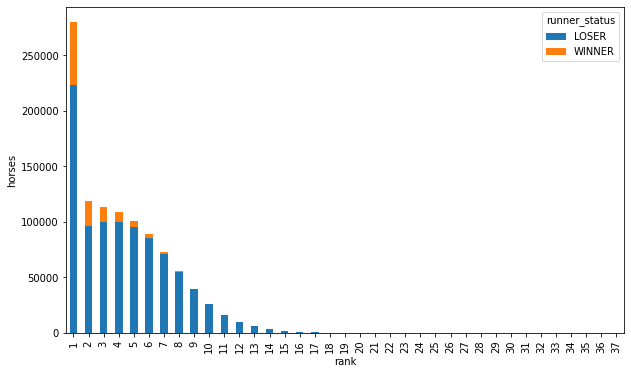

In [68]:
pdf_1.pivot('rank', 'runner_status', 'count').plot(kind = 'bar', stacked=True, ylabel = 'horses')

<AxesSubplot:xlabel='rank', ylabel='horses'>

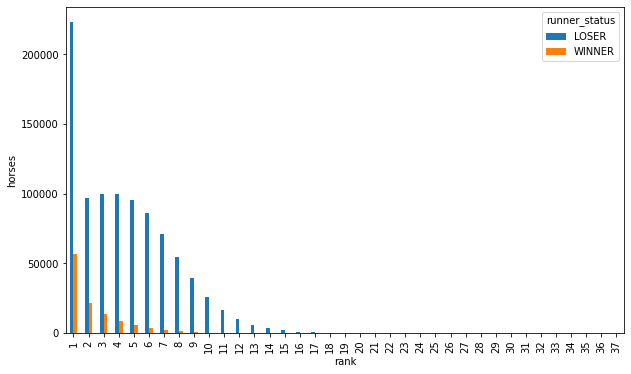

In [71]:
pdf_1.pivot('rank', 'runner_status', 'count').plot(kind = 'bar', stacked=False, ylabel = 'horses')

<AxesSubplot:xlabel='runner_status', ylabel='horses'>

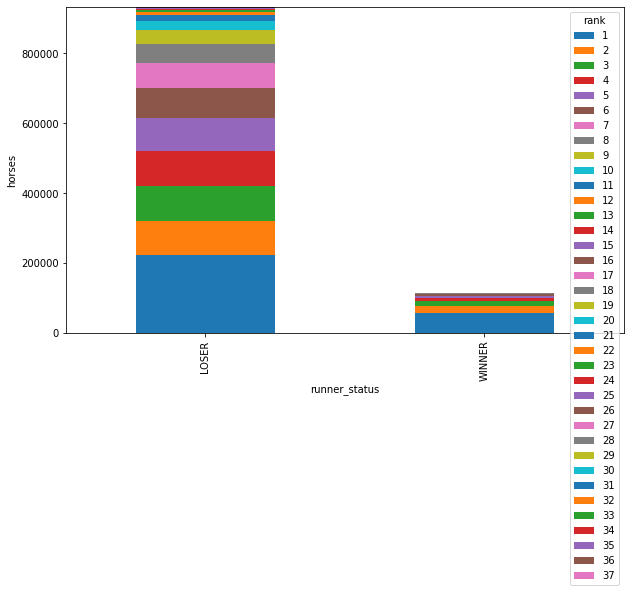

In [151]:
pdf_1.pivot('runner_status', 'rank', 'count').plot(kind = 'bar', stacked=True, ylabel = 'horses')

In [95]:
pdf_1.pivot('runner_status', 'rank', 'count')

rank,1,2,3,4,5,6,7,8,9,10,...,28,29,30,31,32,33,34,35,36,37
runner_status,,,,,,,,,,,,,,,,,,,,,
LOSER,222958.0,96694.0,99892.0,100108.0,95454.0,85860.0,70974.0,54596.0,39276.0,26014.0,...,8.0,8.0,8.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
WINNER,56582.0,21828.0,13560.0,8774.0,5644.0,3668.0,2184.0,1334.0,662.0,392.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
#pdf_1.pivot('rank', 'runner_status', 'count')
#pdf_1['percent'] = (pdf_1.groupby("runner_status").['count'] / pdf_1.groupby("runner_status")['count'].sum()) * 100

pdf_1.groupby(["runner_status"]).agg({"count" : "sum"})

,count
runner_status,
LOSER,933032
WINNER,115100


In [113]:
pdf_1.groupby(["runner_status"])\
.agg({"count" : "sum"})[["count"]]\
.apply(lambda x: 100*x/x.sum())\
.sort_values(by="count", ascending=False)

,count
runner_status,
LOSER,89.018559
WINNER,10.981441


In [116]:
pdf_winners = pdf_1.loc[pdf_1['runner_status'] == "WINNER"]

In [123]:
winner_percentages = pdf_winners.groupby(["rank"])\
.agg({"count" : "sum"})[["count"]]\
.apply(lambda x: 100*x/x.sum())\
.sort_values(by="count", ascending=False)

<AxesSubplot:title={'center':'Winner Distribution by Rank'}, xlabel='rank', ylabel='Percentage of Winners'>

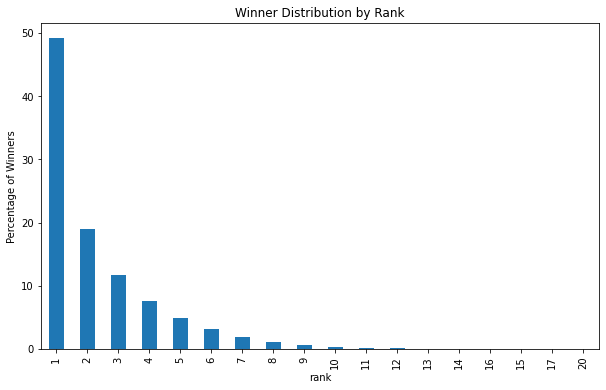

In [133]:
winner_percentages.plot(kind = 'bar', stacked=False, ylabel = 'Percentage of Winners', legend=False, title = 'Winner Distribution by Rank')

In [134]:
pdf_losers = pdf_1.loc[pdf_1['runner_status'] == "LOSER"]

In [141]:
loser_percentages = pdf_losers.groupby(["rank"])\
.agg({"count" : "sum"})[["count"]]\
.apply(lambda x: 100*x/x.sum())\
.sort_values(by="count", ascending=False)

<AxesSubplot:title={'center':'Loser Distribution by Rank'}, xlabel='rank', ylabel='Percentage of Losers'>

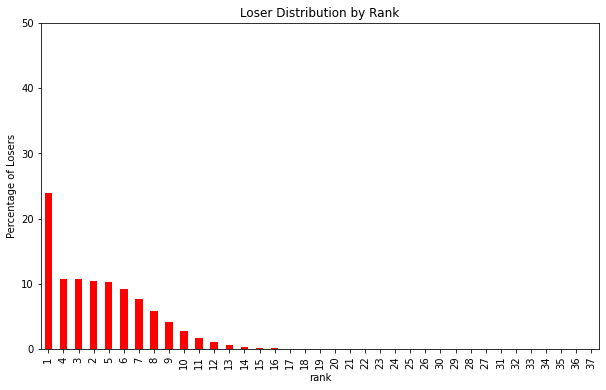

In [139]:
loser_percentages.plot(kind = 'bar', stacked=False, ylabel = 'Percentage of Losers', legend=False, title = 'Loser Distribution by Rank', ylim=(0,50), color='r')

In [ ]:
runners_wbsp_GoldCup = runners_wbsp.filter(runners_wbsp.event_id=='27653664')

In [22]:
runners_wbsp_GoldCup = runners_wbsp.filter(runners_wbsp.market_name=='2m6f Hcap Chs')

In [23]:
runners_wbsp_GoldCup.show()

+--------------+--------------+-----------+-------------+--------+--------------+---------+--------------+-------------+-----+--------------------+
|operation_type|published_time|  market_id|  market_name|event_id|    event_name|runner_id|   runner_name|runner_status|  bsp|runner_sort_priority|
+--------------+--------------+-----------+-------------+--------+--------------+---------+--------------+-------------+-----+--------------------+
|           mcm| 1463249411903|1.124822324|2m6f Hcap Chs|27794338|Uttox 14th May|  8016385|   Pandy Wells|        LOSER|  6.8|                   1|
|           mcm| 1463249411903|1.124822324|2m6f Hcap Chs|27794338|Uttox 14th May|  8665937|   Dawnieriver|        LOSER|  4.6|                   2|
|           mcm| 1463249411903|1.124822324|2m6f Hcap Chs|27794338|Uttox 14th May|  8170549|    Castletown|        LOSER| 4.68|                   3|
|           mcm| 1463249411903|1.124822324|2m6f Hcap Chs|27794338|Uttox 14th May|  8599385|     Red Penny|      

In [35]:
# Filter down to only the records that have Runners.
runners_only = market_definitions.filter(market_definitions.runners.isNotNull())

# Explode the Runners array.
runners_exploded = runners_only.select(market_definitions.operation_type,
                                       market_definitions.published_time,
                                       market_definitions.market_id,
                                       market_definitions.market_name,
                                       market_definitions.event_id,
                                       market_definitions.event_name,
                                       explode(market_definitions.runners).alias('runner_row'))

# Select the useful fields, and give them user friendly names.
runners = runners_exploded.selectExpr('operation_type',
                                      'published_time',
                                      'market_id',
                                      'market_name',
                                      'event_id',
                                      'event_name',
                                      'runner_row.id AS runner_id',
                                      'runner_row.name AS runner_name',
                                      'runner_row.status AS runner_status',
                                      'runner_row.sortPriority AS runner_sort_priority')

# Filter down to only the records that have rc (runner changes).
rc_only = mc_exploded.filter(mc_exploded.mc_row.rc.isNotNull())

# Explode the rc (runner changes) array.
rc_exploded = rc_only.select(rc_only.op.alias('operation_type'),
                             rc_only.pt.alias('published_time'),
                             rc_only.mc_row.id.alias('market_id'),
                             explode(rc_only.mc_row.rc).alias('runner_change_row'))

rc_exploded = rc_exploded.filter(rc_exploded.market_id=='1.122576498')

# Select the useful fields, and give them user friendly names.
runner_changes = rc_exploded.selectExpr('operation_type',
                                        'published_time',
                                        'market_id',
                                        'runner_change_row.id AS runner_id',
                                        'runner_change_row.ltp AS last_traded_price')



In [36]:
runner_changes.head(10)

21/12/21 14:43:39 WARN TaskSetManager: Lost task 0.0 in stage 23.0 (TID 1083, 172.25.0.10, executor 0): org.apache.spark.sql.catalyst.errors.package$TreeNodeException: Binding attribute, tree: _gen_alias_530#530
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1.applyOrElse(BoundAttribute.scala:75)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1.applyOrElse(BoundAttribute.scala:74)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDown$1(TreeNode.scala:309)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:72)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:309)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDown$3(TreeNode.scala:314)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$mapChildren$1(TreeNode.scala:399)
	at org.apache.

Py4JJavaError: An error occurred while calling o328.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 23.0 failed 4 times, most recent failure: Lost task 0.3 in stage 23.0 (TID 1086, 172.25.0.10, executor 0): org.apache.spark.sql.catalyst.errors.package$TreeNodeException: Binding attribute, tree: _gen_alias_530#530
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1.applyOrElse(BoundAttribute.scala:75)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1.applyOrElse(BoundAttribute.scala:74)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDown$1(TreeNode.scala:309)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:72)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:309)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDown$3(TreeNode.scala:314)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$mapChildren$1(TreeNode.scala:399)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:237)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:397)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:350)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:314)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transform(TreeNode.scala:298)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$.bindReference(BoundAttribute.scala:74)
	at org.apache.spark.sql.execution.GenerateExec.boundGenerator$lzycompute(GenerateExec.scala:75)
	at org.apache.spark.sql.execution.GenerateExec.boundGenerator(GenerateExec.scala:75)
	at org.apache.spark.sql.execution.GenerateExec.$anonfun$doExecute$6(GenerateExec.scala:101)
	at org.apache.spark.sql.execution.LazyIterator.results$lzycompute(GenerateExec.scala:36)
	at org.apache.spark.sql.execution.LazyIterator.results(GenerateExec.scala:36)
	at org.apache.spark.sql.execution.LazyIterator.hasNext(GenerateExec.scala:37)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$ConcatIterator.advance(Iterator.scala:198)
	at scala.collection.Iterator$ConcatIterator.hasNext(Iterator.scala:225)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:340)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:872)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:872)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.RuntimeException: Couldn't find _gen_alias_530#530 in [op#3,pt#4L,_gen_alias_529#529]
	at scala.sys.package$.error(package.scala:30)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1.$anonfun$applyOrElse$1(BoundAttribute.scala:81)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 40 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:467)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:420)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3448)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3616)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:763)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3614)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3445)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: Binding attribute, tree: null
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1.applyOrElse(BoundAttribute.scala:75)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1.applyOrElse(BoundAttribute.scala:74)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDown$1(TreeNode.scala:309)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:72)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:309)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDown$3(TreeNode.scala:314)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$mapChildren$1(TreeNode.scala:399)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:237)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:397)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:350)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:314)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transform(TreeNode.scala:298)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$.bindReference(BoundAttribute.scala:74)
	at org.apache.spark.sql.execution.GenerateExec.boundGenerator$lzycompute(GenerateExec.scala:75)
	at org.apache.spark.sql.execution.GenerateExec.boundGenerator(GenerateExec.scala:75)
	at org.apache.spark.sql.execution.GenerateExec.$anonfun$doExecute$6(GenerateExec.scala:101)
	at org.apache.spark.sql.execution.LazyIterator.results$lzycompute(GenerateExec.scala:36)
	at org.apache.spark.sql.execution.LazyIterator.results(GenerateExec.scala:36)
	at org.apache.spark.sql.execution.LazyIterator.hasNext(GenerateExec.scala:37)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$ConcatIterator.advance(Iterator.scala:198)
	at scala.collection.Iterator$ConcatIterator.hasNext(Iterator.scala:225)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:340)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:872)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:872)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.RuntimeException: Couldn't find _gen_alias_530#530 in [op#3,pt#4L,_gen_alias_529#529]
	at scala.sys.package$.error(package.scala:30)
	at org.apache.spark.sql.catalyst.expressions.BindReferences$$anonfun$bindReference$1.$anonfun$applyOrElse$1(BoundAttribute.scala:81)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 40 more


In [37]:
# This market_id is for the a Thurles race in Jan 2016
selection_condition = "market_id = '1.122576498'"

chosen_runners = runners.filter(selection_condition).selectExpr('market_id', 
                                                                'event_name', 
                                                                'market_name', 
                                                                'runner_id', 
                                                                'runner_name').distinct()

# Runners have a 1:many relationship to Runner Changes, so do an inner join from Runners to Runner Changes.
chosen_runner_changes = chosen_runners.join(runner_changes, chosen_runners.runner_id == runner_changes.runner_id).select(
                        chosen_runners.market_id, 
                        chosen_runners.event_name, 
                        chosen_runners.market_name, 
                        chosen_runners.runner_id, 
                        chosen_runners.runner_name,
                        runner_changes.published_time,
                        runner_changes.last_traded_price
                        ).orderBy('published_time').collect()

In [38]:
chosen_runners.show()

+-----------+--------------+-------------+---------+-----------------+
|  market_id|    event_name|  market_name|runner_id|      runner_name|
+-----------+--------------+-------------+---------+-----------------+
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  5415401|         Miradane|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  7011147|         He Rocks|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  7281856|          Tooreen|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  5568158|     Mister First|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  9153264|         Flynsini|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  6939953|Coolnagorna Giggs|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  8996652|      Shadow Play|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  7253717|             Gary|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  8742358|  Topper Thornton|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|   444842|     Winter Magic|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  9483270|  Mountain Philip|
+-----

In [42]:
from pyspark.sql import Row

In [46]:
crc = spark.createDataFrame(chosen_runner_changes)

In [58]:
crc.head(10)

[Row(market_id='1.122576498', event_name='Thurl 14th Jan', market_name='2m6f Hcap Chs', runner_id=7281856, runner_name='Tooreen', published_time=1452767238628, last_traded_price=6.6),
 Row(market_id='1.122576498', event_name='Thurl 14th Jan', market_name='2m6f Hcap Chs', runner_id=9483270, runner_name='Mountain Philip', published_time=1452780920197, last_traded_price=28.0),
 Row(market_id='1.122576498', event_name='Thurl 14th Jan', market_name='2m6f Hcap Chs', runner_id=5415401, runner_name='Miradane', published_time=1452782540168, last_traded_price=12.0),
 Row(market_id='1.122576498', event_name='Thurl 14th Jan', market_name='2m6f Hcap Chs', runner_id=7281856, runner_name='Tooreen', published_time=1452782720244, last_traded_price=9.6),
 Row(market_id='1.122576498', event_name='Thurl 14th Jan', market_name='2m6f Hcap Chs', runner_id=5415401, runner_name='Miradane', published_time=1452784220185, last_traded_price=10.5),
 Row(market_id='1.122576498', event_name='Thurl 14th Jan', market_n

In [48]:
crc.count()

1646

In [49]:
crc = crc.dropDuplicates()

In [59]:
crc.count()

823

In [56]:
crc.sort("published_time").show(truncate=False)

+-----------+--------------+-------------+---------+-----------------+--------------+-----------------+
|market_id  |event_name    |market_name  |runner_id|runner_name      |published_time|last_traded_price|
+-----------+--------------+-------------+---------+-----------------+--------------+-----------------+
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|6939953  |Coolnagorna Giggs|1452712450381 |7.8              |
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|5568158  |Mister First     |1452713642583 |10.5             |
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|8742358  |Topper Thornton  |1452714439156 |9.0              |
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|7281856  |Tooreen          |1452715024612 |6.8              |
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|7281856  |Tooreen          |1452715099578 |6.0              |
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|444842   |Winter Magic     |1452715511351 |4.9              |
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|7281856  |Tooreen     

In [69]:
#1452712450381
#1452778820221
crc.show(823)

+-----------+--------------+-------------+---------+-----------------+--------------+-----------------+
|  market_id|    event_name|  market_name|runner_id|      runner_name|published_time|last_traded_price|
+-----------+--------------+-------------+---------+-----------------+--------------+-----------------+
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  7281856|          Tooreen| 1452767238628|              6.6|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  9483270|  Mountain Philip| 1452780920197|             28.0|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  5415401|         Miradane| 1452782540168|             12.0|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  7281856|          Tooreen| 1452782720244|              9.6|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  5415401|         Miradane| 1452784220185|             10.5|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  7011147|         He Rocks| 1452778160171|              7.2|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  7281856|          To

In [70]:
crc1 = crc["runner_name", "published_time", "last_traded_price"]

In [71]:
crc1.head()

Row(runner_name='Tooreen', published_time=1452767238628, last_traded_price=6.6)

In [75]:
crc1 = crc1.filter(crc1.runner_name=="Tooreen")

In [77]:
crc1.show()

+-----------+--------------+-----------------+
|runner_name|published_time|last_traded_price|
+-----------+--------------+-----------------+
|    Tooreen| 1452767238628|              6.6|
|    Tooreen| 1452782720244|              9.6|
|    Tooreen| 1452781820149|              8.6|
|    Tooreen| 1452782420173|              9.0|
|    Tooreen| 1452783980201|             10.0|
|    Tooreen| 1452782959982|              9.6|
|    Tooreen| 1452784760229|             20.0|
|    Tooreen| 1452783380201|             10.5|
|    Tooreen| 1452780560251|              6.6|
|    Tooreen| 1452716594350|              5.1|
|    Tooreen| 1452779840164|              6.8|
|    Tooreen| 1452781880185|              9.0|
|    Tooreen| 1452764175163|              7.4|
|    Tooreen| 1452777800233|              6.6|
|    Tooreen| 1452775160197|              6.4|
|    Tooreen| 1452774380145|              6.0|
|    Tooreen| 1452757758581|              6.4|
|    Tooreen| 1452781760163|              8.2|
|    Tooreen|

AttributeError: 'DataFrame' object has no attribute 'plot'

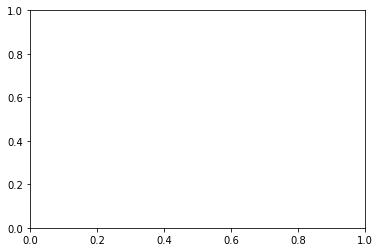

In [81]:
# Create an axes object 
axes = plt.gca()

# pass the axes object to plot function
crc1.plot.line(kind='line', x='published_time', y='last+traded_price', ax=axes);

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
import time

In [63]:
import matplotlib.pyplot as pyplot     

In [42]:
# Betfair time seems to be in milliseconds, so this converts it to normal Unix epoch time in seconds.
def betfair_to_epoch(betfair_time):
    return betfair_time / 1000

# Convert a string like '30.08.2018 17:30:00' to a time number.
def string_to_epoch(time_str):
    pattern = '%d.%m.%Y %H:%M:%S'
    return time.mktime(time.strptime(time_str, pattern))

In [80]:
string_to_epoch('14.03.2016 19:00:00')

1457982000.0

In [79]:
betfair_to_epoch('1452774920.200')

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [61]:
# Plot data inside this date range.
from_time = '1452712450381' #string_to_epoch('14.03.2016 01:00:00')
to_time = '1452778820221' #string_to_epoch('14.03.2016 19:00:00')

#from_time = from_time.astype(float)
#to_time = to_time.astype(float)

from_time = int(from_time)
to_time = int(to_time)


# Make a dictionary of the lowest prices that each runner achieved.
runner_lowest_price = {}       # Key=runner_id, Value=Lowest price they traded at.
runner_volume = {}             # Key=runner_id, Value=Number of market change events they had.
total_volume = 0               # Total number of market change events (total for all runners).

# Analyse all of the runner changes for the selected market.
#for rc in chosen_runner_changes:
   # if (    betfair_to_epoch(rc.published_time) >= from_time 
    #    and betfair_to_epoch(rc.published_time) <= to_time):

for rc in chosen_runner_changes:
    if (    rc.published_time >= from_time 
        and rc.published_time <= to_time):
    
        if not rc.runner_id in runner_lowest_price:
            runner_lowest_price[rc.runner_id] = rc.last_traded_price
        elif rc.last_traded_price < runner_lowest_price[rc.runner_id]:
            runner_lowest_price[rc.runner_id] = rc.last_traded_price

        if not rc.runner_id in runner_volume:
            runner_volume[rc.runner_id] = 1
        else:
            runner_volume[rc.runner_id] = runner_volume[rc.runner_id] + 1

        total_volume += 1

# List of colours that will be used later on for plotting lines.
colours = ['blue', 'green', 'red', 'cyan', 'magenta','yellow', 'black']
            
# Pick runners with lowest prices and high enough volumes, and put their keys into the best_runners list.
# These are the runners that will have their data plotted.
best_runners = []

for i in range(len(runner_lowest_price)):         # All of the runners will be considered as possible to be plotted.
    # Next runner to be considered is the one who traded at the lowest price.
    best_left = min(runner_lowest_price, key=runner_lowest_price.get)
    
    if (i < len(colours)                                         # Can't pick more runners than there are colours to plot.
        and (runner_volume[best_left] / total_volume) > 0.01):   # Runner must be subject of at least 1% of the data points.
            best_runners.append(best_left)
    
    del runner_lowest_price[best_left]                           # Remove runner that has just been considered from the list.

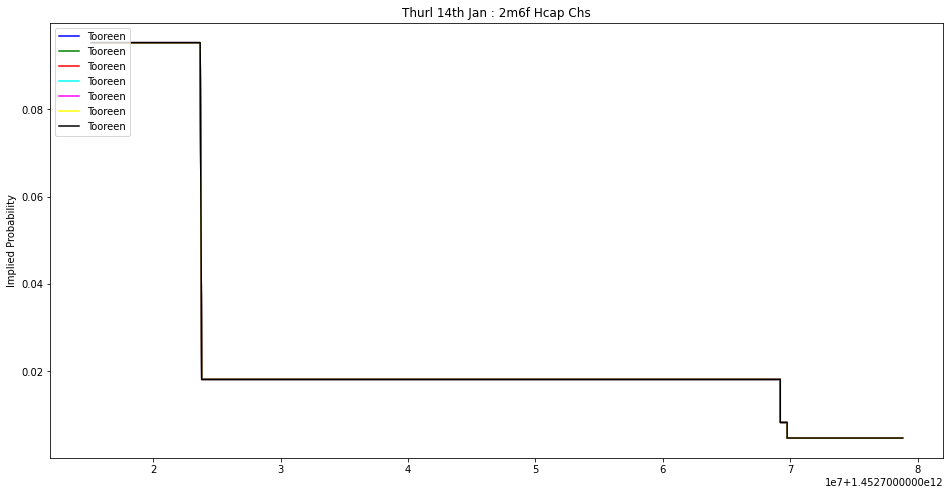

In [64]:
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(16, 8))
curr_colour = 0

sample_size = 10        # Can be adjusted to smooth out data if there are outlier prices sometimes.

# Plot graphs for the list of best runners (lowest priced runners) found in previous cell.
for br in best_runners:
    one_runner_x = []
    one_runner_y = []

    samples = []                          # Buffer of recent last_traded_price for this runner.
    for rc in chosen_runner_changes:
        if (rc.published_time >= from_time 
            and rc.published_time <= to_time):

                
            samples.append(rc.last_traded_price)

            # Only plot this data point if the samples buffer is full sized.
            if len(samples) >= sample_size:
                one_runner_x.append(rc.published_time)
                one_runner_y.append(1 / max(samples))  # Use median price paid in samples buffer.
                one_runner_name = rc.runner_name

    if len(samples) >= sample_size:
        ax.plot(one_runner_x, one_runner_y, color = colours[curr_colour], label = one_runner_name)
        curr_colour += 1

pyplot.legend(loc='upper left')

ax.set(ylabel='Implied Probability',
       title=chosen_runner_changes[0].event_name + ' : ' + chosen_runner_changes[0].market_name)

# Reformat the x axis tick labels.
x_locs, x_labels = pyplot.xticks()
new_x_labels = []
new_x_locs = []
for l in x_locs[1:-1]:                   # Omit the first and last ticks.
    new_x_locs.append(l)
    


# Reformat the y axis tick labels.
y_locs, y_labels = pyplot.yticks()
new_y_labels = []
new_y_locs = []
for l in y_locs[1:-1]:                   # Omit the first and last ticks.
    new_y_locs.append(l)
    


pyplot.show()

In [73]:
runner_volume           # Key=runner_id, Value=Number of market change events they had.

{444842: 464,
 6939953: 86,
 5568158: 50,
 8742358: 46,
 7281856: 100,
 7253717: 20,
 7011147: 126,
 5415401: 30,
 8996652: 28,
 9483270: 30,
 9153264: 20}

In [85]:
runner_lowest_price

{}

In [75]:
total_volume

1000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


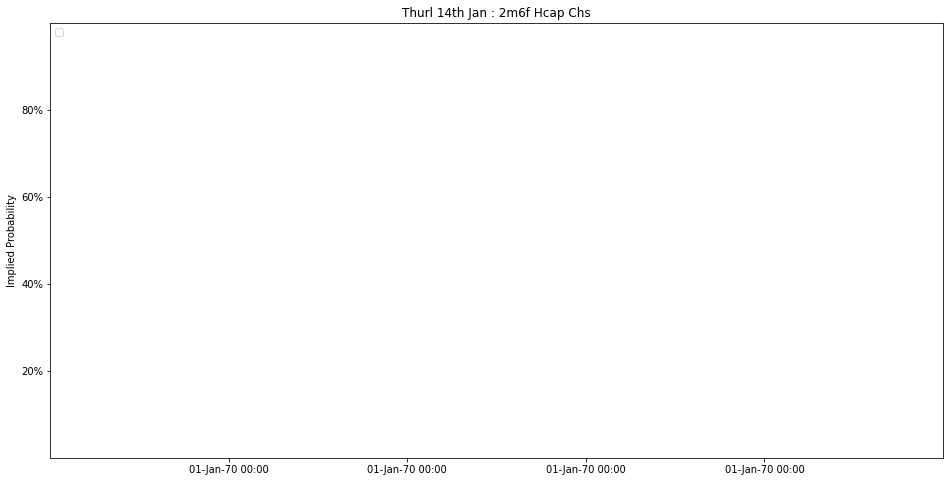

In [83]:
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(16, 8))
curr_colour = 0

sample_size = 1        # Can be adjusted to smooth out data if there are outlier prices sometimes.

# Plot graphs for the list of best runners (lowest priced runners) found in previous cell.
for br in best_runners:
    one_runner_x = []
    one_runner_y = []

    samples = []                          # Buffer of recent last_traded_price for this runner.
    for rc in chosen_runner_changes:
        if (rc.runner_id == br 
            and betfair_to_epoch(rc.published_time) >= from_time 
            and betfair_to_epoch(rc.published_time) <= to_time):

            if len(samples) >= sample_size:        # If the samples buffer is full...
                del samples[0]                     # ... remove the oldest item from it.
                
            samples.append(rc.last_traded_price)

            # Only plot this data point if the samples buffer is full sized.
            if len(samples) >= sample_size:
                one_runner_x.append(betfair_to_epoch(rc.published_time))
                one_runner_y.append(1 / max(samples))  # Use median price paid in samples buffer.
                one_runner_name = rc.runner_name

    if len(samples) >= sample_size:
        ax.plot(one_runner_x, one_runner_y, color = colours[curr_colour], label = one_runner_name)
        curr_colour += 1

pyplot.legend(loc='upper left')

ax.set(ylabel='Implied Probability',
       title=chosen_runner_changes[0].event_name + ' : ' + chosen_runner_changes[0].market_name)

# Reformat the x axis tick labels.
x_locs, x_labels = pyplot.xticks()
new_x_labels = []
new_x_locs = []
for l in x_locs[1:-1]:                   # Omit the first and last ticks.
    new_x_locs.append(l)
    
    # Reformat the x axis tick labels from numbers into nice date/time text format.
    new_x_labels.append(time.strftime('%d-%b-%y %H:%M', time.localtime(l)))
pyplot.xticks(new_x_locs, new_x_labels)

# Reformat the y axis tick labels.
y_locs, y_labels = pyplot.yticks()
new_y_labels = []
new_y_locs = []
for l in y_locs[1:-1]:                   # Omit the first and last ticks.
    new_y_locs.append(l)
    
    # Reformat the y axis tick labels from decimals into nice percentage text format.
    new_y_labels.append(str(int(l * 100)) + '%')
pyplot.yticks(new_y_locs, new_y_labels)

pyplot.show()

In [20]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_wbsp.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+------+--------------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|   bsp|runner_sort_priority|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+------+--------------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10575249|       Bitsys Half|        LOSER|  13.5|                   5|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10288198|         Blue Code|        LOSER|  32.0|                   6|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10116126|            Zartan|        LOSER| 57.95|                   7|
|           mcm| 1462501034557|1.1246591

In [21]:
#############################

In [22]:
# Select the useful fields, and give them user friendly names.
runners = runners_exploded.selectExpr('operation_type',
                                      'published_time',
                                      'market_id',
                                      'market_name',
                                      'event_id',
                                      'event_name',
                                      'runner_row.id AS runner_id',
                                      'runner_row.name AS runner_name',
                                      'runner_row.status AS runner_status',
                                      'runner_row.sortPriority AS runner_sort_priority')

In [23]:
# Filter down to only the records that have rc (runner changes).
rc_only = mc_exploded.filter(mc_exploded.mc_row.rc.isNotNull())

In [24]:
# Explode the rc (runner changes) array.
rc_exploded = rc_only.select(rc_only.op.alias('operation_type'),
                             rc_only.pt.alias('published_time'),
                             rc_only.mc_row.id.alias('market_id'),
                             explode(rc_only.mc_row.rc).alias('runner_change_row'))

In [25]:
# Select the useful fields, and give them user friendly names.
runner_changes = rc_exploded.selectExpr('operation_type',
                                        'published_time',
                                        'market_id',
                                        'runner_change_row.id AS runner_id',
                                        'runner_change_row.ltp AS last_traded_price')

In [26]:
runners.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|runner_sort_priority|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10861746|          B Brazin|      REMOVED|                   1|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May|  4517788|       Great Value|      REMOVED|                   2|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May|   187960|        Kid Creole|      REMOVED|                   3|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5t

In [27]:
# https://www.researchgate.net/publication/351844751_Sonic_Thunder_vs_Brian_the_Snail_Are_people_affected_by_uninformative_racehorse_names
fast_names = [
    'a mile a minute', 'helter-skelter', 'quick-fire',
    'apace', 'high-speed quickly',
    'as fast as your legs would carry you',
    'hot', 'quickness',
    'as if it is going out of style', 'hotfoot', 'rapid',
    'at a rate of knots', 'hustle', 'rapid-fire',
    'at full pelt', 'in the twinkling of an eye',
    'rate',
    'at full speed', 'Jack Robinson', 'say',
    'at full tilt', 'lick', 'shot',
    'at full tilt', 'lickety-split', 'smartly',
    'before you can say Jack Robinson', 'lightning', 'souped-up',
    'blistering', 'like a shot', 'spanking',
    'breakneck' 'like a streak of lightning', 'speed',
    'brisk' 'like lightning spread', 'like wildfire',
    'chop-chop', 'meteoric', 'streak',
    'crash', 'mile', 'style',
    'express', 'nimble', 'superfast',
    'fast', 'nimbleness', 'supersonic',

    'fleet', 'nimbly', 'swift',
    'full', 'nippy', 'swiftly',
    'full steam ahead', 'pdq', 'thick',
    'gallop', 'pell-mell', 'thick and fast',
    'galloping', 'poky', 'tilt',
    'go like hot cakes', 'posthaste', 'top',
    'have a heavy foot', 'precipitous', 'twinkling',
    'headlong', 'precipitously', 'whoosh',
    'heavy', 'prompt', 'wildfire',
    'hell', 'promptly', 'zippy',
    'hell for leather', 'quick',


    'accelerated', 'high-speed', 'pell-mell',
    'at full speed', 'hurried', 'post-haste',
    'at full tilt', 'hurriedly', 'quick',
    'at speed', 'in a flash', 'quickly',
    'at the speed of light', 'in a hurry', 'rapid',
    'blistering', 'in a trice', 'rapidly',
    'breakneck', 'in a wink', 'smart',
    'brisk', 'in haste', 'speedily',
    'briskly', 'in time', 'speedy',
    'energetically', 'in no time at all', 'sporty',
    'expeditious', 'in the blink of an eye', 'sprightly',
    'expeditiously', 'like a flash', 'swift',
    'express', 'like a shot', 'swiftly',
    'fast', 'like an arrow from a bow', 'turbo',
    'fast-moving', 'lively', 'unhesitating',
    'fleet-footed', 'meteoric', 'whirlwind',
    'flying', 'nimble', 'with all haste',
    'hastily', 'on the double', 'with dispatch',
    'hasty', 'pell-mell', 'without delay',

    'acceleration', 'haste', 'scutter',
    'alacrity', 'hasten', 'sharpness',
    'blast', 'hurriedness', 'shoot',
    'bolt', 'hurry', 'spank along',
    'bowl along', 'hurry', 'speed',
    'briskness', 'hurtle', 'speediness',
    'career', 'immediacy', 'sprint',
    'celerity', 'momentum', 'stampede',
    'charge', 'pace', 'streak',
    'dart', 'precipitateness', 'sweep',
    'dash', 'promptness', 'swiftness',
    'dispatch', 'quickness', 'swoop',
    'expedition', 'race', 'tempo',
    'expeditiousness', 'rapidity', 'uzz',
    'fastness', 'rate', 'velocity',
    'flash', 'rattle along', 'whirl',
    'fly', 'run', 'whizz',
    'gallop', 'rush', 'whoosh',
    'go hell for leather', 'scramble', 'wing',
    'go like lightning', 'scud', 'zoom',
    'hare', 'scurry',

    'abrupt', 'impetuous', 'rushed',
    'agility', 'outrun', 'scramble',
    'dash', 'overhasty', 'speed',
    'disconcerted', 'overrun', 'speedily',
    'dodge', 'promptly', 'speedy',
    'haste', 'quick', 'sudden',
    'hastily', 'quickly', 'suddenly',
    'hurried', 'rapid', 'swift',
    'hurriedly', 'rapidly', 'swiftly',
    'hurry', 'rush', 'zoom',

    'accelerate', 'haste', 'race',
    'acceleration', 'hasten', 'rapidity',
    'agility', 'hie', 'rush',
    'airspeed', 'hurriedly', 'speedy',
    'celerity', 'hurry', 'stronghold',
    'dash', 'pace', 'swift',
    'decelerate', 'quick', 'swiftness',
    'expedite', 'quicken', 'tempo',
    'fast', 'quickly', 'urgently',
    'fastness', 'quickness', 'velocity',

    'Apache', 'Bentley', 'Blustery',
    'Bullet', 'Buzz', 'Comet',
    ',Cougar', ',Falcon', 'Faster',
    'Flash', 'Ghost', 'rider', 'Harley',
    'Jet', 'Jump', 'Jumping',
    'Miles', 'Mustang', 'Pony express',
    'Quick', 'Quicky', 'Racer',
    'Rapid', 'Rapide', 'Rocket',
    'Sonic', 'Speedy', 'Taz',
    'Tornado', 'Traveler', 'Wildfire',
    'Voyager', 'Wild', 'Velocity', 

    'Sonic Power', 'Speed Dragon', 'Zippy Lad', 'Lightening Vault',
    'Powerful Jet', 'Orbit Express', 'Swift Chap', 'Blazing Tempo',
    'Brave Falcon', 'Rush Now', 'Top Magic', 'Dixie Flyer',
    'Esprit De Bullet', 'Strike Fast', 'Hustle Hard', 'Diamond Rush',
    'Crown Me Fast', 'Hot Seat', 'Top Gear', 'Bright Bullet',
    'Quick Art', 'Rush Of Blood', 'Top Boy', 'Meteoric',
    'Moments',
    'One Wild Guy', 'Sonic Thunder', 'Grand Gallop', 'Zippy Speed',
    'Run for Roses', 'Saratoga',
    'Wildcat',
    'Quick Beers', 'Sudden Rush',
    'Flyingwithoutwings', 'Fast On', 'Dazzlem Quick', 'You Drive I Fly',
    'Irish Rocket', 'Hot Sauce', 'Mighty Flying', 'frost'
]

In [28]:
for i in range(len(fast_names)):
    fast_names[i] = fast_names[i].lower()

In [29]:
runners = runners.filter(runners.runner_status!='REMOVED')

In [30]:
runners.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|runner_sort_priority|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10575249|       Bitsys Half|        LOSER|                   5|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10288198|         Blue Code|        LOSER|                   6|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10116126|            Zartan|        LOSER|                   7|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5t

In [31]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType, StringType, DoubleType

In [32]:
@udf(BooleanType())
def is_fast(name):
    if name is None:
        return False
    name = name.lower()
    for s in fast_names:
        if s in name:
            return True
    return False

In [33]:
from pyspark.sql.functions import lit, col

In [34]:
runners_fast = runners.withColumn('is_fast_horse',  is_fast(runners.runner_name))

In [35]:
#############################
### aisling with bsp data
runners_fast_wbsp = runners_wbsp.withColumn('is_fast_horse',  is_fast(runners_wbsp.runner_name)) 

In [36]:
### aisling with bsp data
runners_fast_wbsp = runners_fast_wbsp.filter(runners_fast_wbsp.bsp.isNotNull())

In [37]:
runners_fast_wbsp = runners_fast_wbsp.filter(runners_fast_wbsp.bsp!='None')

In [38]:
runners_fast_wbsp = runners_fast_wbsp.filter(runners_fast_wbsp.bsp!='NaN')

In [39]:
runners_fast_wbsp.dtypes

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('bsp', 'string'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [40]:
runners_fast_wbsp.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+------+--------------------+-------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|   bsp|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+------+--------------------+-------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10575249|       Bitsys Half|        LOSER|  13.5|                   5|        false|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10288198|         Blue Code|        LOSER|  32.0|                   6|        false|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10116126|            Zartan|        LOSER

In [41]:
## turning bsp to integer type
from pyspark.sql.types import IntegerType

In [42]:
runners_fast_wbsp = runners_fast_wbsp.withColumn("bsp", runners_fast_wbsp["bsp"].cast(IntegerType()))

In [43]:
runners_fast_wbsp.dtypes

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('bsp', 'int'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [44]:
#runners_fast_wbsp.count()

In [45]:
#############################

In [46]:
runners_fast.dtypes

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [47]:
runners_fast.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+-------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+-------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10575249|       Bitsys Half|        LOSER|                   5|        false|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10288198|         Blue Code|        LOSER|                   6|        false|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10116126|            Zartan|        LOSER|                   7|        false

In [48]:
runners_fast_only = runners_fast

In [49]:
runners_fast_only = runners_fast.filter(runners_fast.is_fast_horse=='true')

In [50]:
runners_fast_only.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+-------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+-------------+
|           mcm| 1462495994956|1.124659121|    R5 6f Claim|27784588|EvangD (US) 5th May| 10116132|      Als Wild Cat|        LOSER|                   3|         true|
|           mcm| 1462492394718|1.124659115|R3 5f Mdn Claim|27784588|EvangD (US) 5th May| 11133644|       Smart Heath|        LOSER|                   4|         true|
|           mcm| 1462494555563|1.124659118|    R4 7f Claim|27784588|EvangD (US) 5th May| 10059691|Run Mardi Gras Run|        LOSER|                   2|         true

In [51]:
runners_fast_only_win = runners_fast_only.filter(runners_fast_only.runner_status=='WINNER')

In [52]:
runners_fast_only_win.show()

+--------------+--------------+-----------+------------------+--------+--------------------+---------+----------------+-------------+--------------------+-------------+
|operation_type|published_time|  market_id|       market_name|event_id|          event_name|runner_id|     runner_name|runner_status|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+------------------+--------+--------------------+---------+----------------+-------------+--------------------+-------------+
|           mcm| 1462549406066|1.124660844|           7f Hcap|27785040|        Ling 6th May|  4776418|       Space War|       WINNER|                   5|         true|
|           mcm| 1462549406066|1.124660844|           7f Hcap|27785040|        Ling 6th May|  4776418|       Space War|       WINNER|                   5|         true|
|           mcm| 1462487628442|1.124659140|       R2 1m Claim|27784591|   Penn (US) 5th May|  9979505|Wild Imagination|       WINNER|                   2| 

In [53]:
###########################

In [54]:
runners_fast_wbsp_sample = runners_fast_wbsp.limit(1000)

In [ ]:
runners_fast_wbsp_sample.show(100)

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [ ]:
columns_to_drop = ['operation_type', 'published_time', 'market_id', 'market_name', 'event_id', 'event_name', 'runner_id', 'runner_name', 'runner_sort_priority' ]


In [ ]:
runners_fast_wbsp_sample1 = runners_fast_wbsp_sample.drop(*columns_to_drop)

In [ ]:
runners_fast_wbsp_sample1.show()

In [ ]:
### Sum of two or more columns in pyspark

from pyspark.sql.functions import col

In [ ]:
runners_fast_wbsp_sample2=runners_fast_wbsp_sample1.withColumn("implied_prob", 1/col("bsp"))

In [ ]:
runners_fast_wbsp_sample2.show(10)

In [ ]:
columns_to_drop = ["bsp"]
runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.drop(*columns_to_drop)

In [ ]:
runners_fast_wbsp_sample2.groupby("runner_status").count().show()

In [ ]:
runners_fast_wbsp_sample2.groupby("is_fast_horse").count().show()

In [ ]:
runners_fast_wbsp_sample2.show()

In [ ]:
!pip install numpy

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.withColumn("is_fast_horse_num", runners_fast_wbsp_sample2["is_fast_horse"].cast(IntegerType()))

In [ ]:
runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.drop("is_fast_horse")

In [ ]:
runners_fast_wbsp_sample2.dtypes

In [ ]:
runners_fast_wbsp_sample2.show(1)

In [ ]:
cols = runners_fast_wbsp_sample2.columns

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['is_fast_horse_num']
#  is_fast_horse, runner_status, implied_prob
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'runner_status', outputCol = 'label')

stages += [label_stringIdx]

numericCols = ['implied_prob']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

In [ ]:
# pipline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(runners_fast_wbsp_sample2)
runners_fast_wbsp_sample2 = pipelineModel.transform(runners_fast_wbsp_sample2)


In [ ]:
selectedCols = ['label', 'features'] + cols
runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.select(selectedCols)
runners_fast_wbsp_sample2.printSchema()

In [ ]:
runners_fast_wbsp_sample2.head()

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd

In [ ]:
runners_fast_wbsp_sample2.dtypes

In [ ]:
pd.DataFrame(runners_fast_wbsp_sample2.take(5), columns=runners_fast_wbsp_sample2.columns).transpose()

In [ ]:
train, test = runners_fast_wbsp_sample2.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [ ]:
!pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
predictions = lrModel.transform(test)
predictions.select('is_fast_horse_num', 'implied_prob').show(10)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

In [ ]:
lrModel.coefficients

the bigger the coefficient the more predictive power it has

Winner = 1, Loser = 0
Winner = X*is_fast + Y*implied_prob


the bigger the coefficient the more predictive power it has

is_fast=0, is_not_fast=1
Winner = 1, Loser = 0
Winner = -0.2172*is_fast + 5.2113*implied_prob

In [ ]:
print("Multinomial coefficients: " + str(lrModel.coefficientMatrix))


In [ ]:
print("Multinomial intercepts: " + str(lrModel.interceptVector))

In [ ]:
lrModel.summary()

In [ ]:
### gold cup 2016

In [24]:
gold_cup = market_definitions.filter(market_definitions["event_name"]=="Chel 18th Mar")

In [25]:
gold_cup.show()

+--------------+--------------+--------------+---------+---+---------+------------+----------+--------------+--------+------------+--------------+----------------+--------+----------+-------------+-------+----------------+-----------+-----------+------------------------+-----------------+---------+-------------------+----------------+------------+------+------------+--------+--------------------+-------+-----------+----------+-------+
|operation_type|sequence_token|published_time|market_id| rc|bet_delay|betting_type|bsp_market|bsp_reconciled|complete|country_code|cross_matching|discount_allowed|event_id|event_name|event_type_id|in_play|market_base_rate|market_time|market_type|number_of_active_runners|number_of_winners|open_date|persistence_enabled|runners_voidable|settled_time|status|suspend_time|timezone|turn_in_play_enabled|version|market_name|regulators|runners|
+--------------+--------------+--------------+---------+---+---------+------------+----------+--------------+--------+----

In [ ]:
# connector is called 'mysql-connector-python'
# Google it and what you want to do
import mysql.connector

mydb = mysql.connector.connect(
  host="mysql",
  user="ssbd",
  password="pass",
  database='analysis_db'
)

print(mydb)

In [ ]:
# https://stackoverflow.com/questions/44893565/get-list-of-mysql-databases-with-python
cursor = mydb.cursor()
databases = ("show databases")
cursor.execute(databases)
for (databases) in cursor:
     print (databases[0])

In [ ]:
#https://www.geeksforgeeks.org/how-to-show-all-tables-in-mysql-using-python/
mycursor = mydb.cursor()
mycursor.execute("Show tables;")
myresult = mycursor.fetchall()
 
for x in myresult:
    print(x)